# Letter Recognition Using SVM

Let's now tackle a slightly more complex problem - letter recognition. We'll first explore the dataset a bit, prepare it (scale etc.) and then experiment with linear and non-linear SVMs with various hyperparameters.


## Data Understanding 

Let's first understand the shape, attributes etc. of the dataset.

In [2]:
# libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

# dataset
letters = pd.read_csv("letter-recognition.csv")

In [3]:
# about the dataset

# dimensions
print("Dimensions: ", letters.shape, "\n")

# data types
print(letters.info())

# head
letters.head()

Dimensions:  (20000, 17) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
letter    20000 non-null object
xbox      20000 non-null int64
ybox      20000 non-null int64
width     20000 non-null int64
height    20000 non-null int64
onpix     20000 non-null int64
xbar      20000 non-null int64
ybar      20000 non-null int64
x2bar     20000 non-null int64
y2bar     20000 non-null int64
xybar     20000 non-null int64
x2ybar    20000 non-null int64
xy2bar    20000 non-null int64
xedge     20000 non-null int64
xedgey    20000 non-null int64
yedge     20000 non-null int64
yedgex    20000 non-null int64
dtypes: int64(16), object(1)
memory usage: 2.6+ MB
None


,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [5]:
# a quirky bug: the column names have a space, e.g. 'xbox ', which throws and error when indexed
print(letters.columns)


Index(['letter', 'xbox ', 'ybox ', 'width ', 'height', 'onpix ', 'xbar ',
       'ybar ', 'x2bar', 'y2bar ', 'xybar ', 'x2ybar', 'xy2bar', 'xedge ',
       'xedgey', 'yedge ', 'yedgex'],
      dtype='object')


In [6]:
# let's 'reindex' the column names
letters.columns = ['letter', 'xbox', 'ybox', 'width', 'height', 'onpix', 'xbar',
       'ybar', 'x2bar', 'y2bar', 'xybar', 'x2ybar', 'xy2bar', 'xedge',
       'xedgey', 'yedge', 'yedgex']
print(letters.columns)

Index(['letter', 'xbox', 'ybox', 'width', 'height', 'onpix', 'xbar', 'ybar',
       'x2bar', 'y2bar', 'xybar', 'x2ybar', 'xy2bar', 'xedge', 'xedgey',
       'yedge', 'yedgex'],
      dtype='object')


In [7]:
order = list(np.sort(letters['letter'].unique()))
print(order)


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


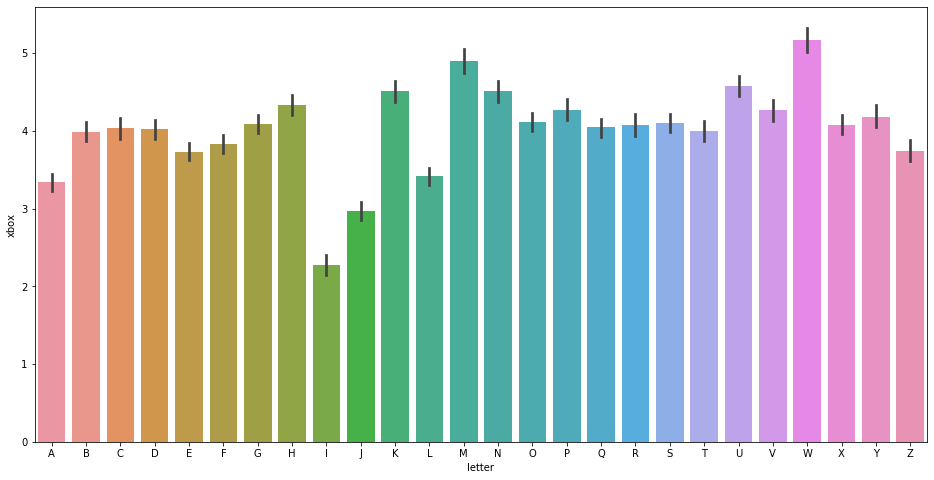

In [8]:
# basic plots: How do various attributes vary with the letters

plt.figure(figsize=(16, 8))
sns.barplot(x='letter', y='xbox', 
            data=letters, 
            order=order)

In [11]:
letter_means = letters.groupby('letter').mean()
letter_means

,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
letter,,,,,,,,,,,,,,,,
A,3.337136,6.975919,5.128010,5.178707,2.991128,8.851711,3.631179,2.755387,2.043093,7.802281,2.338403,8.465146,2.771863,6.321926,2.875792,7.468948
B,3.985640,6.962141,5.088773,5.169713,4.596606,7.671018,7.062663,5.366841,5.571802,7.954308,5.506527,6.652742,3.117493,7.919060,6.612272,9.100522
C,4.031250,7.063859,4.701087,5.296196,2.775815,5.437500,7.627717,5.927989,7.177989,8.773098,7.494565,11.947011,1.991848,8.876359,4.080163,8.555707
D,4.023602,7.244720,5.170186,5.288199,4.026087,7.539130,6.806211,5.921739,6.508075,8.166460,5.111801,5.750311,3.365217,7.813665,3.971429,7.628571
E,3.727865,6.944010,4.756510,5.201823,3.679688,5.966146,7.352865,4.223958,7.585938,8.507812,6.242188,10.341146,2.127604,8.298177,6.022135,8.506510
F,3.832258,7.009032,4.898065,5.209032,3.178065,4.913548,10.454194,3.476129,4.886452,11.242581,7.830968,5.723871,1.736774,9.117419,3.321290,6.712258
G,4.086675,6.988357,4.988357,5.282018,3.566624,6.866753,6.586028,5.966365,5.337646,7.429495,6.157827,9.586028,2.833118,8.369987,5.146184,9.216041
H,4.331063,6.844687,5.784741,5.193460,4.253406,7.344687,7.320163,6.702997,4.280654,8.044959,5.899183,7.801090,3.862398,8.047684,3.095368,7.858311
I,2.270199,6.980132,2.631788,5.209272,1.825166,7.458278,7.035762,1.940397,5.973510,9.476821,5.797351,7.649007,0.537748,8.066225,2.141722,7.931126


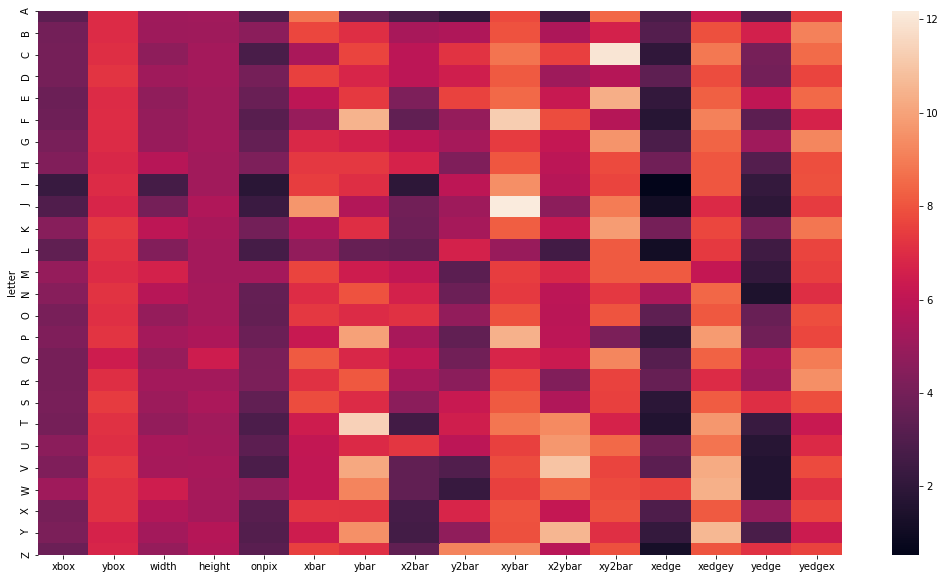

In [12]:

plt.figure(figsize=(18, 10))
sns.heatmap(letter_means)

## Data Preparation

Let's conduct some data preparation steps before modeling. Firstly, let's see if it is important to **rescale** the features, since they may have varying ranges. For example, here are the average values:

In [13]:
# average feature values
round(letters.drop('letter', axis=1).mean(), 2)

xbox      4.02
ybox      7.04
width     5.12
height    5.37
onpix     3.51
xbar      6.90
ybar      7.50
x2bar     4.63
y2bar     5.18
xybar     8.28
x2ybar    6.45
xy2bar    7.93
xedge     3.05
xedgey    8.34
yedge     3.69
yedgex    7.80
dtype: float64

In this case, the average values do not vary a lot (e.g. having a diff of an order of magnitude). Nevertheless, it is better to rescale them.

In [15]:
# splitting into X and y
X = letters.drop("letter", axis = 1)
y = letters['letter']
X.head()

,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [18]:
# scaling the features
X_scaled = scale(X)


# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 101)

## Model Building

Let's fist build two basic models - linear and non-linear with default hyperparameters, and compare the accuracies.

In [21]:
# linear model

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
y_pred = model_linear.predict(X_test)

In [22]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.8523333333333334 

[[198   0   0   0   0   0   1   1   0   1   1   1   0   0   0   0   0   1
    0   1   1   0   0   0   3   0]
 [  0 188   0   3   0   1   3   3   1   0   1   0   0   2   0   1   1   9
    3   0   0   1   0   1   0   0]
 [  1   0 200   0   7   0  12   1   0   0   5   0   0   0   3   0   0   0
    0   0   1   0   0   0   0   0]
 [  1  15   0 210   0   1   2   2   1   0   1   0   1   5   3   0   0   5
    0   1   0   0   0   0   0   0]
 [  0   1   3   0 204   2   6   1   0   0   1   5   0   0   0   0   2   2
    1   2   0   0   0   1   0   3]
 [  0   0   0   1   1 201   1   2   1   1   0   0   0   2   0   2   0   0
    3   7   1   0   1   0   1   0]
 [  0   1   9   4   2   2 167   1   0   1   4   3   1   0   1   0   9   1
    8   0   0   2   3   0   0   0]
 [  0   7   3  11   0   4   3 141   0   2   4   1   2   0  12   0   4  12
    0   0   4   2   0   4   1   0]
 [  0   0   2   3   0   6   0   0 184   9   0   0   0   0   1   0   0   0
    3   0   0   0   0  

The linear model gives approx. 85% accuracy. Let's look at a sufficiently non-linear model with randomly chosen hyperparameters.

In [23]:
# non-linear model
# using rbf kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='rbf')

# fit
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_test)

/Users/vijaybmani/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [24]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.9383333333333334 

[[205   0   0   1   0   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   2   0]
 [  0 205   0   3   1   0   1   0   0   0   0   0   0   0   0   0   0   6
    1   0   0   0   0   1   0   0]
 [  0   0 213   0   5   0   7   1   0   0   0   0   0   0   4   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   4   0 234   0   0   1   3   0   0   0   0   0   3   1   0   0   2
    0   0   0   0   0   0   0   0]
 [  0   0   0   0 221   1   9   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0   0   2]
 [  0   0   0   1   0 215   1   1   1   0   0   0   0   1   0   1   0   0
    1   3   0   0   0   0   0   0]
 [  0   0   3   4   1   1 202   0   0   0   0   1   1   0   2   0   0   1
    0   0   0   1   2   0   0   0]
 [  0   7   0   5   0   0   4 177   0   0   2   0   1   0   3   0   4  13
    0   0   1   0   0   0   0   0]
 [  0   0   1   1   0   3   0   0 194  11   0   0   0   0   0   1   0   0
    2   0   0   0   0  

The non-linear model gives approx. 93% accuracy. Thus, going forward, let's choose hyperparameters corresponding to non-linear models.

## Grid Search: Hyperparameter Tuning

Let's now tune the model to find the optimal values of C and gamma corresponding to an RBF kernel. We'll use 5-fold cross validation.

In [29]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  8.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [27]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.111482,0.045130,1.322461,0.041609,1,0.01,"{'C': 1, 'gamma': 0.01}",0.826429,0.834643,0.828571,...,0.832714,0.006221,7,0.843929,0.844196,0.847679,0.843571,0.844018,0.844679,0.001514
1,4.412161,0.040221,1.628749,0.038560,1,0.001,"{'C': 1, 'gamma': 0.001}",0.684643,0.672500,0.682500,...,0.677214,0.005622,10,0.682054,0.683125,0.687946,0.679554,0.686429,0.683821,0.003021
2,8.377263,0.116001,1.681986,0.012302,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.203929,0.207143,0.206429,...,0.217571,0.014490,12,0.212679,0.217589,0.228393,0.240625,0.240625,0.227982,0.011507
3,1.304060,0.006950,0.848505,0.008180,10,0.01,"{'C': 10, 'gamma': 0.01}",0.914643,0.908571,0.902500,...,0.911214,0.005654,3,0.929643,0.929464,0.930357,0.928929,0.928125,0.929304,0.000746
4,2.061808,0.025278,1.268774,0.031322,10,0.001,"{'C': 10, 'gamma': 0.001}",0.805714,0.809643,0.803571,...,0.808929,0.006227,8,0.818125,0.817679,0.819643,0.814375,0.819464,0.817857,0.001897
5,4.330812,0.101985,1.591368,0.047589,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.684286,0.671071,0.682500,...,0.677000,0.005788,11,0.681875,0.683304,0.687500,0.680089,0.685446,0.683643,0.002608
6,1.541319,0.041125,0.668988,0.020861,100,0.01,"{'C': 100, 'gamma': 0.01}",0.948571,0.946786,0.941429,...,0.947786,0.003742,2,0.978482,0.977946,0.978393,0.978661,0.978571,0.978411,0.000249
7,1.592164,0.023864,0.947624,0.012207,100,0.001,"{'C': 100, 'gamma': 0.001}",0.861071,0.866071,0.850357,...,0.863357,0.008074,5,0.879554,0.877143,0.882143,0.875536,0.879464,0.878768,0.002262
8,2.147549,0.017569,1.324435,0.012032,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.801071,0.806429,0.803929,...,0.805714,0.006140,9,0.813571,0.812679,0.814286,0.810000,0.815357,0.813179,0.001815
9,1.712663,0.012311,0.583702,0.013450,1000,0.01,"{'C': 1000, 'gamma': 0.01}",0.953571,0.949643,0.948571,...,0.951714,0.002183,1,0.997054,0.997768,0.997411,0.997321,0.997232,0.997357,0.000237


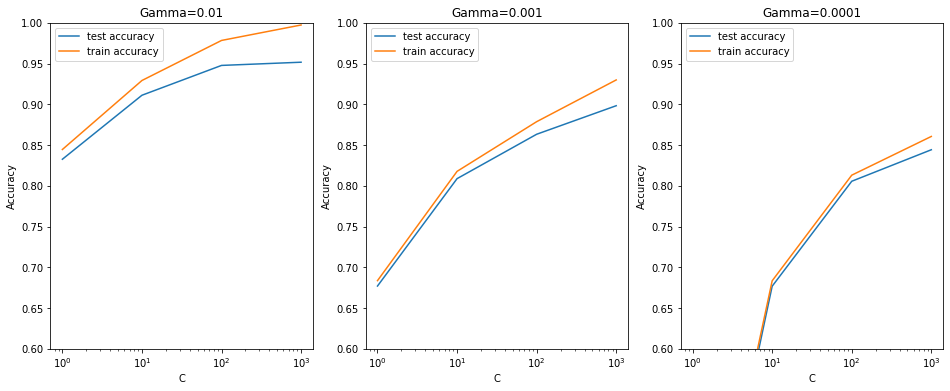

In [28]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


The plots above show some useful insights:
- Non-linear models (high gamma) perform *much better* than the linear ones
- At any value of gamma, a high value of C leads to better performance
- None of the models tend to overfit (even the complex ones), since the training and test accuracies closely follow each other

This suggests that the problem and the data is **inherently non-linear** in nature, and a complex model will outperform simple, linear models in this case.

Let's now choose the best hyperparameters. 

In [19]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9517142857142857 corresponding to hyperparameters {'C': 1000, 'gamma': 0.01}


### Building and Evaluating the Final Model

Let's now build and evaluate the final model, i.e. the model with highest test accuracy.

In [20]:
# model with optimal hyperparameters

# model
model = SVC(C=1000, gamma=0.01, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# metrics
print("accuracy", metrics.accuracy_score(y_test, y_pred), "\n")
print(metrics.confusion_matrix(y_test, y_pred), "\n")



accuracy 0.9596666666666667 

[[206   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   2   0]
 [  0 211   0   2   1   0   1   0   0   0   0   0   0   0   0   0   0   1
    2   0   0   0   0   0   0   0]
 [  0   0 220   0   3   0   4   1   0   0   0   0   0   0   2   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   3   0 236   0   1   0   1   0   1   0   0   0   2   2   0   0   1
    1   0   0   0   0   0   0   0]
 [  0   0   1   0 225   1   4   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   0   0   0   0   2]
 [  0   0   0   1   0 217   0   0   1   1   0   0   0   1   0   3   0   0
    0   0   0   1   0   0   0   0]
 [  0   0   2   3   1   0 209   0   0   0   0   0   1   0   1   0   0   0
    0   0   0   1   1   0   0   0]
 [  0   1   3   5   0   0   2 195   1   1   2   1   1   0   1   0   3   1
    0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   1   0   0 203   8   0   0   0   0   0   0   1   0
    0   0   0   0   0   

## Conclusion

The accuracy achieved using a non-linear kernel (~0.95) is mush higher than that of a linear one (~0.85). We can conclude that the problem is highly non-linear in nature.